<a href="https://colab.research.google.com/github/alleyex/tensorflow_lab/blob/main/predicting_sunspots_with_neural_networks(DNN_only).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [3]:
def plot_series(x, y, format = '-', start = 0, end = None, title = None, xlabel = None, ylabel = None, legend = None ):
  """
  Visualizes time series data

  Args:
    x (array of int): contians values for the x-axis
    y (array of int or tuple of array): contaims the values for the y-axis
    format (string): line style when plotting the graph
    start (int): first time step to plot
    end (int): last time step to plot
    title (string): title of the plot
    xlabel (string): label for the x-axis
    ylabel (string): label for the y-axis
    legend (list of string): legend for the plot
  """

  # Setpu dimenstion s of the graph figure
  plt.figure(figsize = (10, 6))

  # Check if there are more then two series to plot
  if type(y) is tuple:

    # Loop over the y elements
    for y_curr in y:

      # Plot the x and current y values
      plt.plot(x[start: end], y_curr[start: end], format)

  else:
    # Plot the x and y values
    plt.plot(x[start: end], y[start: end], format)

  # Label the x-axis
  plt.xlabel(xlabel)

  # Label the y-axis
  plt.ylabel(ylabel)

  # Set the legend
  if legend:
    plt.legend(legend)

  # Set the title
  plt.title(title)

  # overlay a grid on the graph
  plt.grid(True)

  # Draw the graph on screen
  plt.show()


In [4]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-05-12 04:11:21--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2024-05-12 04:11:21 (67.5 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



In [5]:
# Preview the dataset
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


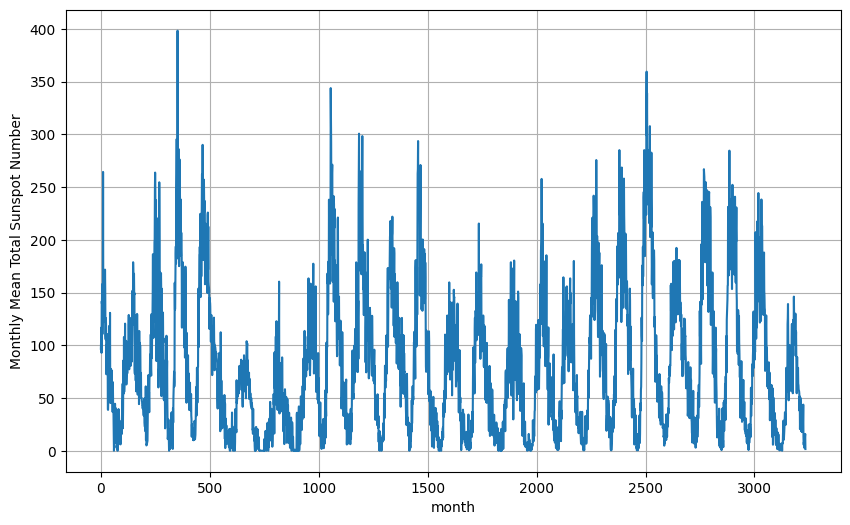

In [9]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open("./Sunspots.csv") as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter = ",")

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel = "month", ylabel = "Monthly Mean Total Sunspot Number")


In [10]:
# Split the Dataset
# Define the split time
split_time = 3000

# get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]


In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """
  Generates dataset windows

  Args:
    series (array of float): contains the values of the time series
    window_size (int): the number of time steps to include in the feature
    batch_size (int): the batch size
    shuffle_buffer (int): buffer size to use for shuffle method

  Returns:
    dataset (tf.data.Dataset): TF Dataset containing time windows
  """

  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only take those with the specified size
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size +1))

  # Create tuples with features and labels
  dataset = dataset.map(lambda window: (window[: -1], window[-1]))

  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset


In [24]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer = shuffle_buffer_size)

In [25]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1251 (4.89 KB)
Trainable params: 1251 (4.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
    )

# initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer)

# Train the model
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule], verbose = 2)


Epoch 1/100
93/93 - 2s - loss: 56.5777 - lr: 1.0000e-08 - 2s/epoch - 18ms/step
Epoch 2/100
93/93 - 0s - loss: 56.1309 - lr: 1.1220e-08 - 488ms/epoch - 5ms/step
Epoch 3/100
93/93 - 0s - loss: 55.6329 - lr: 1.2589e-08 - 454ms/epoch - 5ms/step
Epoch 4/100
93/93 - 0s - loss: 55.0789 - lr: 1.4125e-08 - 458ms/epoch - 5ms/step
Epoch 5/100
93/93 - 0s - loss: 54.4683 - lr: 1.5849e-08 - 472ms/epoch - 5ms/step
Epoch 6/100
93/93 - 0s - loss: 53.7936 - lr: 1.7783e-08 - 472ms/epoch - 5ms/step
Epoch 7/100
93/93 - 0s - loss: 53.0543 - lr: 1.9953e-08 - 449ms/epoch - 5ms/step
Epoch 8/100
93/93 - 0s - loss: 52.2494 - lr: 2.2387e-08 - 446ms/epoch - 5ms/step
Epoch 9/100
93/93 - 0s - loss: 51.3823 - lr: 2.5119e-08 - 444ms/epoch - 5ms/step
Epoch 10/100
93/93 - 0s - loss: 50.4430 - lr: 2.8184e-08 - 454ms/epoch - 5ms/step
Epoch 11/100
93/93 - 0s - loss: 49.4264 - lr: 3.1623e-08 - 449ms/epoch - 5ms/step
Epoch 12/100
93/93 - 0s - loss: 48.3106 - lr: 3.5481e-08 - 474ms/epoch - 5ms/step
Epoch 13/100
93/93 - 0s - l

(1e-08, 0.001, 0.0, 100.0)

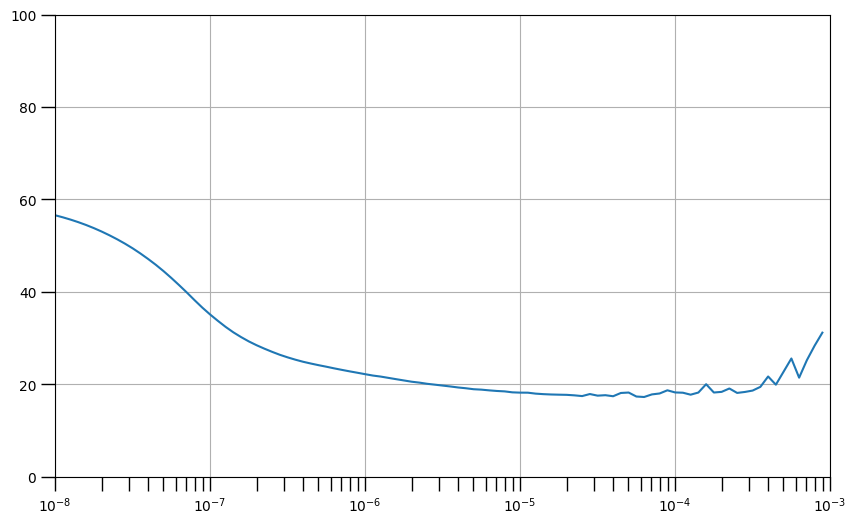

In [27]:
# Define the learning rate array
lrs = 1e-8 * 10**(np.arange(100) / 20)

# Set the figure size
plt.figure(figsize = (10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history['loss'])

# Increase the tickmarks size
plt.tick_params(axis = 'both', length = 10, width = 1, which = 'both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])


In [30]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer)

# Train the model
history = model.fit(train_set, epochs = 100)

In [32]:
def model_forecast(model, series, window_size):
  """
  Uses an input model to generate predictions on data windows

  Args:
    model (tf.keras.Model): model that accepts data windows
    series (array of float): Contains the values of the time series
    window_size (int): the batch size

  Returns:
    forecast (numpy array): array containing predictions
  """

  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only take those with the specified size
  dataset = dataset.window(window_size, shift = 1, drop_remainder = True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size))

  # Create batchs of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  # Gat predictions on the entire dataset
  forecast = model.predict(dataset)

  return forecast


8/8 [==============================] - 0s 11ms/step


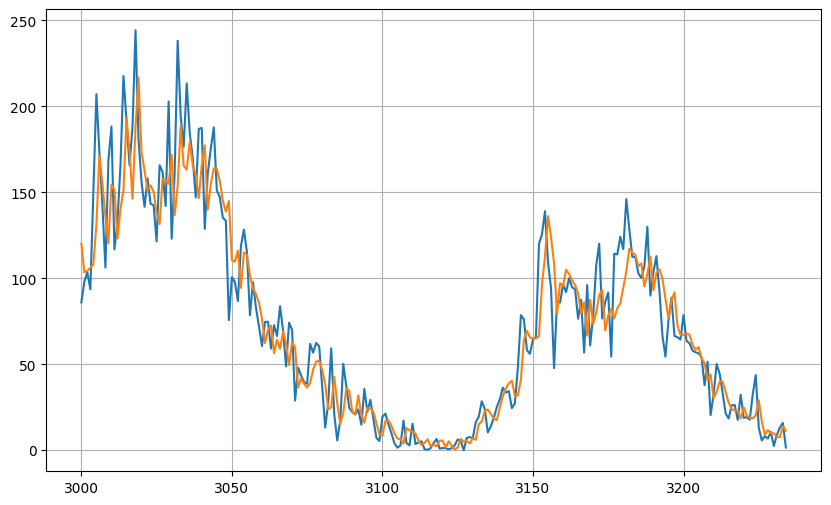

In [33]:
# Reduce the original series
forecast_series = series[split_time - window_size: -1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [35]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.309532
